function to compute numpy representation from video file (thanks Yana!)

In [ ]:
import numpy as np
import cv2
from utils.image import *
from utils.video import *
from utils.pipeutils import *
import os
from os.path import join,isfile,isdir
from os import listdir
from pipe import *
import random
import matplotlib.pyplot as plt
import math
import builtins

In [8]:
import numpy as np
import cv2
import os.path

# trs, let's assume width is always wider than height
def video_to_npy(infile, outfile=None, width=None, height=None, squarecrop=None, fps=None, cropat=None):
    
    # has this video already been saved before?
    if isfile(outfile):
        frames = np.load(outfile)
        if frames.shape[1]==height:
            # just return this preloaded video
            return frames
    
    print('reading fresh video from %s' % infile)
    vidcap = cv2.VideoCapture(infile)
    success, image = vidcap.read()
    
    frames = []
    count = 0
    if not success:
        raise ValueError('Could not read the video file!')
    while success:
        frames.append( image[...,::-1] )
        count += 1
        success,image = vidcap.read()
    if fps:
        span = int(vidcap.get(cv2.CAP_PROP_FPS) / fps)
        frames = frames[0::span] 
    if width or height:  
        width = width if width else int(height / frames[0].shape[0] * frames[0].shape[1])
        height = height if height else int(width / frames[0].shape[1] * frames[0].shape[0])
        frames = [ cv2.resize(frame, (width, height)) for frame in frames ]
    if squarecrop:
        tl = int((width/2)-(height/2))
        # note that x,y is the wrong way around i.e. it's
        # F x Y x X x C
        frames = [ frame[ 0:height, tl:(tl+height)] for frame in frames ]
    if cropat:
        frames = frames[0:cropat*fps]
        
    frames = np.array(frames)
    if outfile:
        np.save(outfile, frames)
    return frames

In [9]:
from random import shuffle
from pipe import *

@Pipe
def pshuffle(l):
    shuffle(l)
    return l
@Pipe
def pcycle(l):
    return cycle(l)

In [10]:
from os import listdir
from os.path import isfile, join
from itertools import *
from pipe import *

# return iterable { (label, path/video1), (label, path/video2), ... }
def GetVideos( path, label, ext='.mp4' ):
    p = listdir(path) | where( lambda p: p.endswith(ext) ) | as_list()
    return zip( repeat(label, len(p)), map( lambda p: join( path, p ), p ) )

In [11]:
import pickle
# dump a classes file so the others can see which classes I have assigned

classes = GetVideos('./videos/collisions', 1) \
    | chain_with(GetVideos('./videos/not-collisions', 0))  \
    | select( lambda i: (i[1].replace('./videos/collisions\\','').replace('./videos/not-collisions\\',''), i[0]) ) \
    | as_dict()

pickle.dump( classes, open( "class_structure.p", "wb" ) ) 

classes

{'output000-26961.mp4': 1,
 'output000-5404.mp4': 1,
 'output000.mp4': 1,
 'output001-24132.mp4': 1,
 'output001-24962.mp4': 1,
 'output001-5404.mp4': 1,
 'output001.mp4': 1,
 'output002-26961.mp4': 1,
 'output002-27378.mp4': 1,
 'output002-4994.mp4': 1,
 'output002-5404.mp4': 1,
 'output002.mp4': 1,
 'output003-24962.mp4': 1,
 'output003-26961.mp4': 1,
 'output003-27378.mp4': 1,
 'output003-5404.mp4': 1,
 'output003.mp4': 1,
 'output004-27378.mp4': 1,
 'output004-31027.mp4': 1,
 'output004-4994.mp4': 1,
 'output004-5404.mp4': 1,
 'output004.mp4': 1,
 'output005-26961.mp4': 1,
 'output005-4360.mp4': 1,
 'output005-5404.mp4': 1,
 'output005.mp4': 1,
 'output006-24132.mp4': 1,
 'output006-24962.mp4': 1,
 'output006-26961.mp4': 1,
 'output006-27378.mp4': 1,
 'output006-4994.mp4': 1,
 'output006-5404.mp4': 1,
 'output006.mp4': 1,
 'output007-24962.mp4': 1,
 'output007-26961.mp4': 1,
 'output007-31027.mp4': 1,
 'output007-4360.mp4': 1,
 'output007-5404.mp4': 1,
 'output007.mp4': 1,
 'output

In [12]:
import uuid
import pickle
import math

collisions = GetVideos('./videos/collisions', 1) | as_list() | pshuffle()
ncollisions = GetVideos('./videos/not-collisions', 0) | as_list() | pshuffle()

# what is the min number in either class?
minn = [ collisions | count, ncollisions | count ] | min

# now let's validate on 33% of that
vs = math.floor( minn * 0.33 )

In [13]:
# run this when you need to
#valset = collisions | take(vs) | chain_with( ncollisions | take(vs) ) | as_list()
# let's save this valsplit to the filesystem for use later!
#pickle.dump( valset, open( "valsplit_%s.p" % uuid.uuid4().hex, "wb" ) ) 

In [14]:
# are you running this later and want to pick up from a previous val split for consistent results?
# important; has the population of videos on the file system changed since this pickle was created?
import pickle
valset = pickle.load( open( "valsplit_1b46b8e12c244afdaf09f83241fb443a.p", "rb" ) )

In [15]:
# how many validation videos?
print(valset | count)

118


In [27]:
# now let's get a stream of train and validation videos which is label-balanced 

def videoStream():
    # handy dict to see if a file is in the validation set
    vd = valset | select( lambda t: (t[1],t[0]) ) | as_dict()
    
    while True:
        #create an infinite sequence of both, taking the same from both to ensure 
        # same average label distribution
        ic = collisions | where( lambda v: v[1] not in vd ) | as_list() | pshuffle() | take(100)
        inc = ncollisions | where( lambda v: v[1] not in vd ) | as_list() | pshuffle() | take(100)

        mixed_stream = ( ic \
            | chain_with( inc )  \
            | as_list()
            # shuffle it so we get good label mix
            | pshuffle() )
        
        for e in mixed_stream:
            yield e

In [28]:
# this is our training stream which is label balanced
stream = videoStream()

for every video in the collisions/non collisions folder, compute the numpy representation 

In [29]:
# adorn the video to the tuple iterator, return cloned+appended tuple
@Pipe
def adornVideo(iterator, framerate=25, video_size=64, max_length=5, squarecrop=True):
    return iterator \
        | select( lambda f: f + ( 
            video_to_npy( f[1], 
                         #note weird thing here, width doesn't work they appear to be inverted
                         height=video_size, 
                         squarecrop=squarecrop, 
                         fps=framerate,
                         cropat=max_length,
                         # save a npy replacement
                         outfile=f[1].replace('.mp4','_%d.npy' % (video_size) )
            ), ) )


reading fresh video from ./videos/not-collisions\output544-14767.mp4
reading fresh video from ./videos/collisions\output017-5404.mp4
reading fresh video from ./videos/not-collisions\output678-14767.mp4
reading fresh video from ./videos/collisions\output094.mp4
reading fresh video from ./videos/not-collisions\output030-26961.mp4


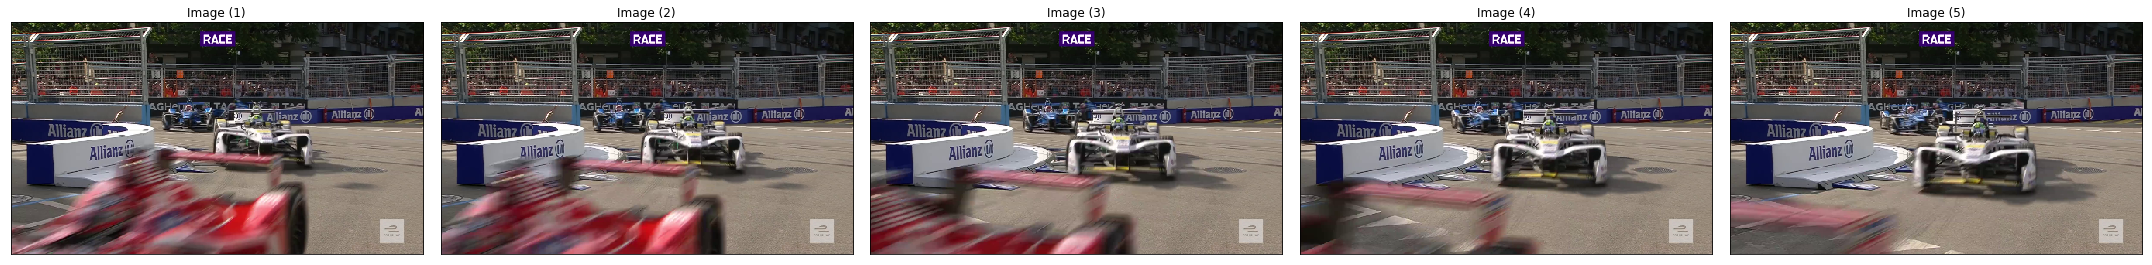

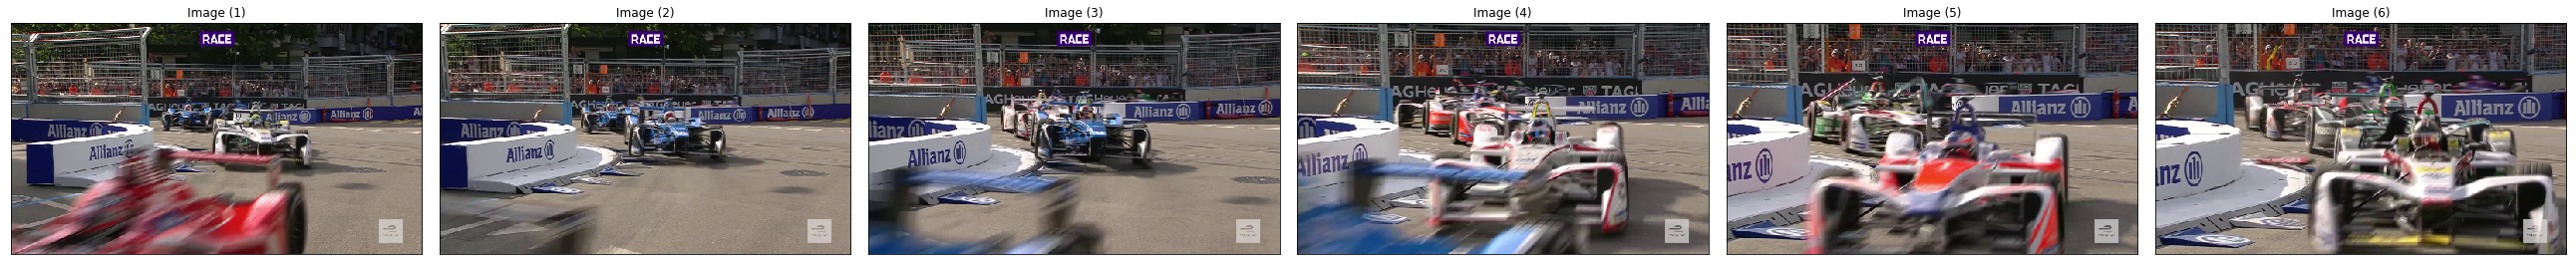

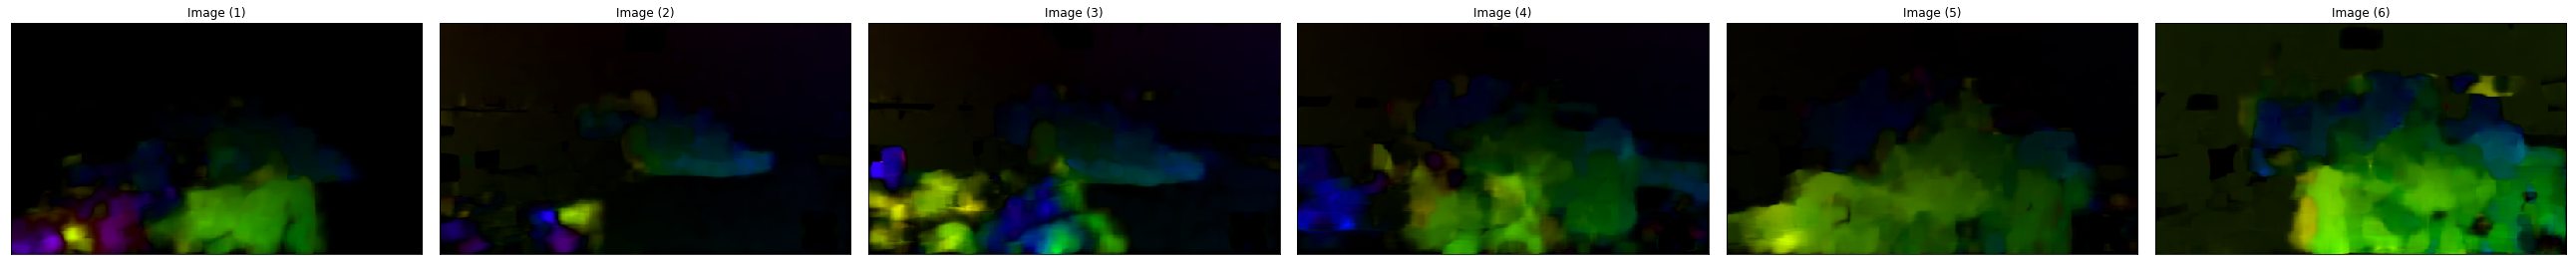

In [32]:
## Compute Dense Optical Flow
sample = stream | adornVideo(video_size=300,squarecrop=False) | skip(3) | take(1) | as_list
frames = sample[0][2][:,:,:,0:5]
show_images(frames[0:5])

# get n sample frames from the video
def sample_idx(video,n=5):
    return range(0,len(video),len(video)//n)

def sample_frames(video):
    return video[sample_idx(video)]

fs = sample_frames(frames)
show_images(fs)

def dense_flow(frame1, frame2):
    f1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    f2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    return cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

def visualize_flow_hsv(frame1, flow):
    hsvImg = np.zeros_like(frame1)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

show_images([visualize_flow_hsv(frames[i],dense_flow(frames[i],frames[i+1])) for i in sample_idx(frames)])

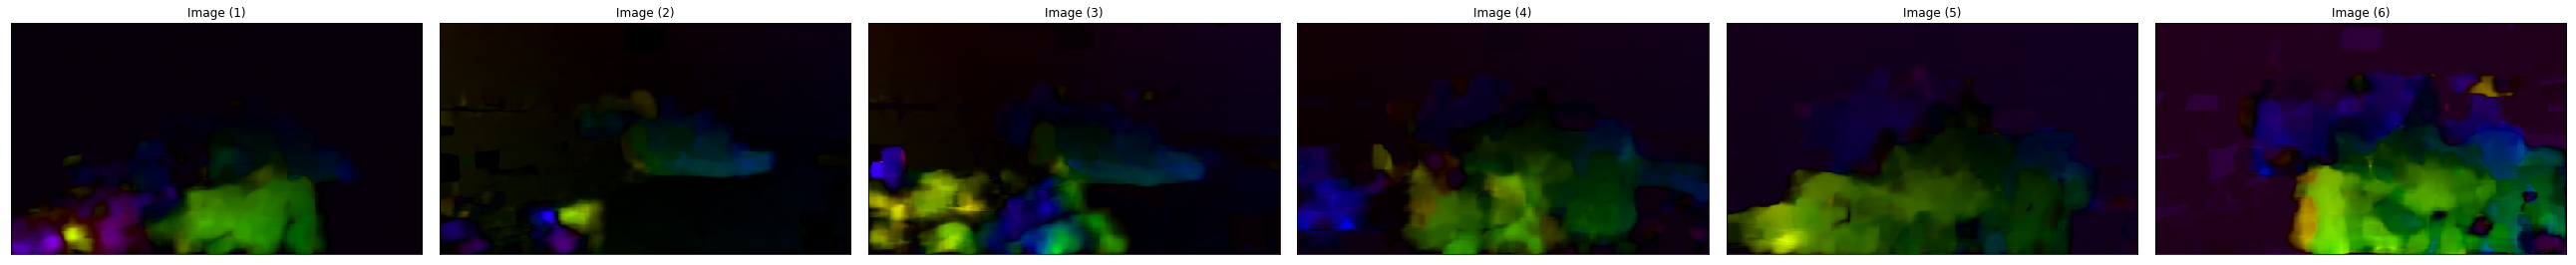

In [33]:
# Some naive stabilization
def dense_flow_stab(frame1, frame2):
    f = dense_flow(frame1, frame2)
    vec = np.average(f,axis=(0,1))
    mask = f==0
    f = f-vec
    f[mask]=0
    return f

show_images([visualize_flow_hsv(frames[i],dense_flow_stab(frames[i],frames[i+1])) for i in sample_idx(frames)])

Histograms of x and y displacements

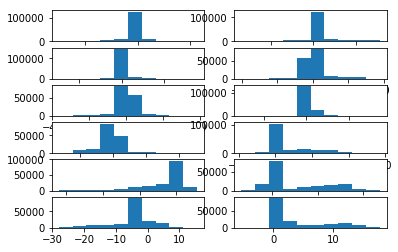

In [44]:
fig, ax = plt.subplots(len(fs),2)

for i,x in enumerate(fs):
    ax[i,0].hist(x[:,:,0].ravel())
    ax[i,1].hist(x[:,:,1].ravel())
plt.show()

Histogram of direction/magnitude

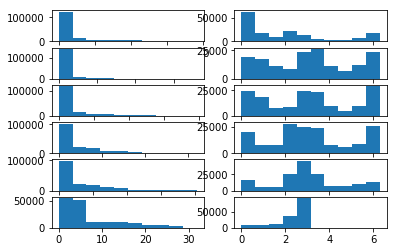

In [46]:
fs = [dense_flow(frames[i],frames[i+1]) for i in range(0,len(frames),len(frames)//5)]
fig, ax = plt.subplots(len(fs),2)
for i,x in enumerate(fs):
    mag, ang = cv2.cartToPolar(x[..., 0], x[..., 1])
    ax[i,0].hist(mag[:,:].ravel())
    ax[i,1].hist(ang[:,:].ravel())
plt.show()

Computing histogram for the whole video

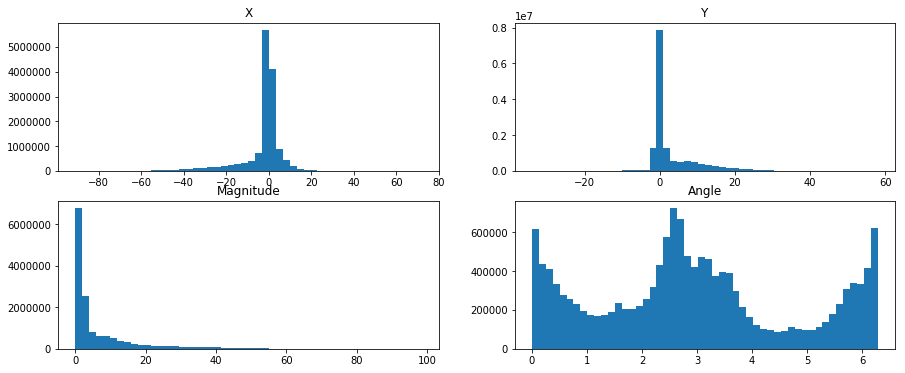

Max magnitude=98.29432678222656


In [47]:
flow = np.array([dense_flow(frames[i],frames[i+1]) for i in range(0,len(frames)-1)])
mag, ang = cv2.cartToPolar(flow[...,0],flow[...,1])
fig,ax=plt.subplots(2,2,figsize=(15,6))
ax[0,0].hist(flow[...,0].ravel(),bins=50); ax[0,0].set_title('X')
ax[0,1].hist(flow[...,1].ravel(),bins=50); ax[0,1].set_title('Y')
ax[1,0].hist(mag.ravel(),bins=50); ax[1,0].set_title('Magnitude')
ax[1,1].hist(ang.ravel(),bins=50); ax[1,1].set_title('Angle')
plt.show()
print("Max magnitude={}".format(mag.max()))

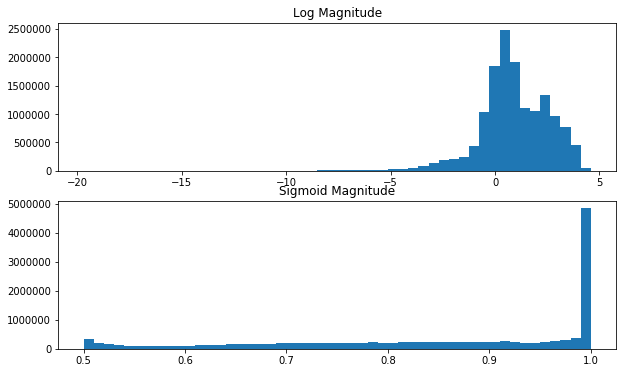

In [48]:
fig,ax=plt.subplots(2,1,figsize=(10,6))
ax[0].hist(np.log(mag.ravel()),bins=50); ax[0].set_title('Log Magnitude')
ax[1].hist(1/(1+np.exp(-mag.ravel())),bins=50); ax[1].set_title('Sigmoid Magnitude')
plt.show()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


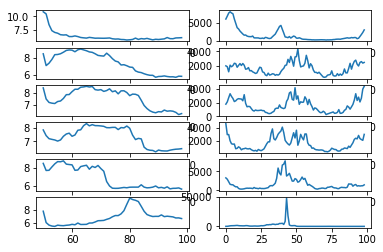

Max magnitude=81.13306427001953


In [50]:
fs = [dense_flow(frames[i],frames[i+1]) for i in range(0,len(frames),len(frames)//5)]
nbins=100
fig, ax = plt.subplots(len(fs),2)
max_mag = 0
for i,x in enumerate(fs):
    mag, ang = cv2.cartToPolar(x[..., 0], x[..., 1])
    ax[i,0].plot(np.log(np.histogram(mag.ravel(),bins=np.arange(nbins)/nbins*10-5)[0])) # we consider log in range -5..5
    ax[i,1].plot(np.histogram(ang.ravel(),bins=np.arange(nbins)/nbins*2*math.pi)[0])
    max_mag=builtins.max(max_mag,mag.max())
plt.show()
print("Max magnitude={}".format(max_mag))

In [51]:
def get_flow_descriptor(video,nbins=100,mag_min=-7,max_max=7):
    def descr(f1,f2,bins,mbins):
        f = dense_flow_stab(f1,f2)
        mag, ang = cv2.cartToPolar(f[..., 0], f[..., 1])
        h1,bins1 = np.histogram(ang.ravel(),bins=bins)
        h2,bins2 = np.histogram(mag.ravel(),bins=mbins)
        return [[x,y] for x,y in zip(h1,np.log(1+h2))] # we take log of histograms to make range smaller
    abins = [i*2*math.pi/nbins for i in range(0,nbins+1)]
    mbins = np.arange(nbins+1)/nbins*(max_mag-mag_min)+mag_min
    return np.array([ descr(video[i],video[i+1],bins=abins,mbins=mbins) for i in range(0,len(video)-1)])

fd = get_flow_descriptor(frames)
print(frames.shape, fd.shape)

(92, 300, 533, 3) (91, 100, 2)


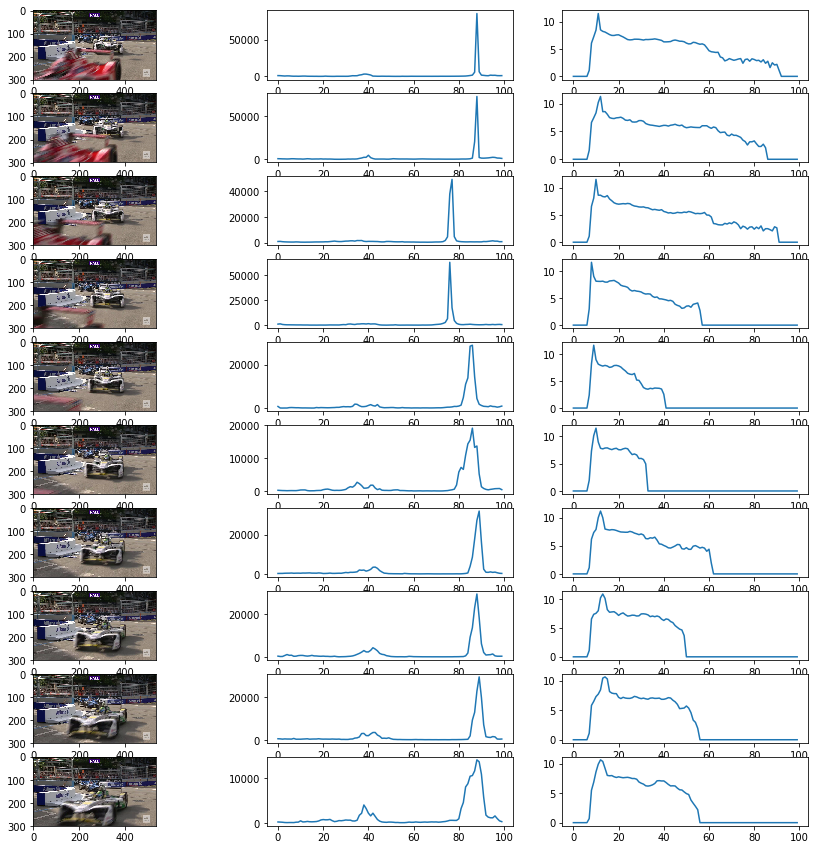

In [54]:
dx=0
fig, ax = plt.subplots(10,3,figsize=(15,15))
for i in range(0,10):
    ax[i,0].imshow(frames[i+dx])
    ax[i,1].plot(fd[i+dx,:,0])
    ax[i,2].plot(fd[i+dx,:,1])
plt.show()

In [ ]:
to_process_flows = stream \
                | where( lambda f: not isfile( f[1].replace('.mp4','.flows.npy') ) )

flows_withvideo = to_process_flows | adornVideo(video_size=300, squarecrop=False)

# write out the vectorflows for each video
for v in flows_withvideo:
    hist = get_flow_descriptor(v[2])
    np.save(v[1].replace('.mp4','.flows.npy'),hist)

reading fresh video from ./videos/collisions\output068-26961.mp4
reading fresh video from ./videos/not-collisions\output595-14767.mp4
reading fresh video from ./videos/collisions\output062-31027.mp4
reading fresh video from ./videos/not-collisions\output075-14767.mp4
reading fresh video from ./videos/collisions\output020.mp4
reading fresh video from ./videos/not-collisions\output014-14767.mp4
reading fresh video from ./videos/collisions\output084-24962.mp4
reading fresh video from ./videos/collisions\output023-27378.mp4
reading fresh video from ./videos/collisions\output091-26961.mp4
reading fresh video from ./videos/not-collisions\output048-5404.mp4
reading fresh video from ./videos/not-collisions\output026-27378.mp4
reading fresh video from ./videos/collisions\output024.mp4
reading fresh video from ./videos/collisions\output009-5404.mp4
reading fresh video from ./videos/not-collisions\output030-27378.mp4
reading fresh video from ./videos/not-collisions\output110.mp4
reading fresh vid

reading fresh video from ./videos/not-collisions\output648-14767.mp4
reading fresh video from ./videos/not-collisions\output348-14767.mp4
reading fresh video from ./videos/not-collisions\output025-5404.mp4
reading fresh video from ./videos/collisions\output050-5404.mp4
reading fresh video from ./videos/not-collisions\output060-26961.mp4
reading fresh video from ./videos/collisions\output007-24962.mp4
reading fresh video from ./videos/not-collisions\output239-14767.mp4
reading fresh video from ./videos/not-collisions\output649-14767.mp4
reading fresh video from ./videos/not-collisions\output031-26961.mp4
reading fresh video from ./videos/not-collisions\output016-5404.mp4
reading fresh video from ./videos/collisions\output042-26961.mp4
reading fresh video from ./videos/collisions\output047.mp4
reading fresh video from ./videos/collisions\output044-4994.mp4
reading fresh video from ./videos/not-collisions\output027.mp4
reading fresh video from ./videos/not-collisions\output007-14767.mp4
r

reading fresh video from ./videos/collisions\output085-26961.mp4
reading fresh video from ./videos/not-collisions\output130.mp4
reading fresh video from ./videos/collisions\output051-5404.mp4
reading fresh video from ./videos/collisions\output004.mp4
reading fresh video from ./videos/collisions\output007-26961.mp4
reading fresh video from ./videos/collisions\output008.mp4
reading fresh video from ./videos/collisions\output007.mp4
reading fresh video from ./videos/collisions\output034-4994.mp4
reading fresh video from ./videos/collisions\output107.mp4
reading fresh video from ./videos/collisions\output041-5404.mp4
reading fresh video from ./videos/not-collisions\output014.mp4
reading fresh video from ./videos/collisions\output066.mp4
reading fresh video from ./videos/collisions\output060-5404.mp4
reading fresh video from ./videos/collisions\output023-4994.mp4
reading fresh video from ./videos/not-collisions\output005-27378.mp4
reading fresh video from ./videos/collisions\output041-24132

reading fresh video from ./videos/collisions\output045-5404.mp4
reading fresh video from ./videos/collisions\output054-24962.mp4
reading fresh video from ./videos/collisions\output056.mp4
reading fresh video from ./videos/collisions\output074.mp4
reading fresh video from ./videos/collisions\output034-5404.mp4
reading fresh video from ./videos/collisions\output045-31027.mp4
reading fresh video from ./videos/collisions\output031-4994.mp4
reading fresh video from ./videos/collisions\output082.mp4
reading fresh video from ./videos/collisions\output012-4994.mp4
reading fresh video from ./videos/collisions\output132.mp4
reading fresh video from ./videos/collisions\output075.mp4


ok, so at this point we now have a numpy array for every single video file! the numpy arrays are fixed on some video size, length and frame rate i.e. 200^2, 5 seconds and 25fps.  

For every single video file, we compute a random augmentation consistently across all of the frames

In [20]:
import random

from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=5,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)

@Pipe
def augmentation( 
    flow,
    colpath='./collisions',
    noncolpath='./not-collisions',
    augment=True, 
    diff=False,
    normalize=True):
   
    for video in flow:
        # for every frame in this video generate the same transformation
        # and yield it all back in sequence order
        trans = image_datagen.get_random_transform(video[2].shape)
        augmentedVideo = np.zeros( video[2].shape )
        for i in range(video[2].shape[0]):
            if augment:
                augmentedVideo[i] = image_datagen.apply_transform(video[2][i], trans)
            else:
                augmentedVideo[i] = video[2][i]
            
            # now is a good time to transform the video onto 0-1
            # we need to do this to get convergence when we train i.e. homogenise features
            if normalize:
                augmentedVideo[i] = augmentedVideo[i] / 255
            
            # take xth order differences of frames to convey pixel-wise temporal changes
            if diff is not None:
                augmentedVideo[i, 0:augmentedVideo[i].shape[0]-diff] = np.diff(augmentedVideo[i], axis=0, n=diff)
            
        yield video[:-1] + (augmentedVideo,)


Using TensorFlow backend.


let's visualize the augmented results for this video

In [21]:
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.xticks([]), plt.yticks([])
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.tight_layout()
    plt.show()
    display()

In [ ]:
train_withvideo_aug = stream |  adornVideo() | augmentation(diff=None, augment=True)
val_withvideo = valset | adornVideo()

def getTestImages(flow, howmany=5):
    augmentedVideo = next(flow)
    print(augmentedVideo[2].shape)
    return range(augmentedVideo[2].shape[0]) \
        | select( lambda i: augmentedVideo[2][i] ) \
        | take(howmany) 

# show some augmented train images
images = getTestImages(train_withvideo_aug)

for x in range(2):
    images = images | chain_with( getTestImages(train_withvideo_aug) )

show_images( images | as_list, cols=4 )

# and do the same for some validation images
images = getTestImages(val_withvideo)
for x in range(2):
    images = images | chain_with( getTestImages(val_withvideo) )

show_images( images | as_list, cols=4 )

ok this is looking pretty good, next thing is to zeropad so that the number of frames is always the same i.e. max seconds * framerate

In [22]:
@Pipe
def zeroPadVideos(videoStream, video_size=64, max_length=5, framerate=25):
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, video_size, video_size, 3 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ,: ] = video[2]
        yield video[:-1] + (zeroPadded,)

# we will need to do the same thing to the validation stream as what happened to the train stream!
@Pipe
def normalizeVideos(videoStream):
    for video in videoStream:
        
        yield ( video[0], video[1], video[2]/255  )

OK the next problem is we have a nice generator for videos, but we are doing a 4d CNN with videos and need a batch dimension, so let's write another generator which will batch X videos at a time

```
next( zeroPadVideos( flow ) )[3].shape
```
== (125, 200, 200, 3)


In [24]:
@Pipe
def getBatchVideosFlow(flow, batchsize=10, video_size=64, max_length=5, framerate=25):
    while(True):
        batch = np.zeros( (batchsize, max_length * framerate, video_size, video_size, 3 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next( flow )
            batch[i] = video[2]
            labels[i] = video[0]
        yield ( batch, labels )

We now have a generator giving us batches of training examples and respective labels, we can feed this into keras fit_generator!

How big is a batch i.e. will it fit in memory?

In [25]:
%%time
from sys import getsizeof

g = train_withvideo_aug = stream \
    |  adornVideo()  \
    | augmentation(diff=None, augment=True)  \
    | zeroPadVideos()  \
    |  getBatchVideosFlow(5)

r = next( g )
# signals one for each video
print(r[0].shape)
# labels one for each video
print(r[1].shape)

print(getsizeof(r[0])/1024**3)
# == 2.4gb for 20 videos of 125 frames @ 200^2*3

# clear r
r=0

(5, 125, 64, 64, 3)
(5, 1)
0.05722060799598694
Wall time: 346 ms


now let's try and train keras on it

In [141]:
video_size = 64
framerate = 25
max_length = 5
batchsize = 10

print('training with videosize: %s framerate: %d' % (video_size, framerate))

# make a fresh stream for clarity
train_stream = ( videoStream() 
    # actually load the respective video into memory
    | adornVideo(framerate=framerate, video_size=video_size, max_length=max_length) 
    # for all frames in this video, randomly augment them in the same way
    #| augmentation(diff=False, augment=False, normalize=True) 
    | normalizeVideos()
    | zeroPadVideos(video_size) 
    # batch into X videos to match Keras modality
    | getBatchVideosFlow( batchsize, video_size ) )

# recall valset is our precomputed list of validation videos (50/50 label split)
val_stream = ( valset 
    | adornVideo(framerate=framerate, video_size=video_size, max_length=max_length) 
    | normalizeVideos()
    | zeroPadVideos(video_size) 
    # we need this to be an infinite sequence for Keras but fear not
    # all validation samples will be returned before a cycle
    | pcycle() 
    | getBatchVideosFlow( batchsize, video_size ) )


training with videosize: 64 framerate: 25


In [145]:
# from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv3D(32,(1, 3, 3), activation='relu', input_shape=(max_length * framerate, video_size, video_size, 3)))
model.add(layers.AveragePooling3D((1, 5, 5)))
model.add(layers.MaxPooling3D((10, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_101 (Conv3D)          (None, 125, 62, 62, 32)   896       
_________________________________________________________________
average_pooling3d_31 (Averag (None, 125, 12, 12, 32)   0         
_________________________________________________________________
max_pooling3d_99 (MaxPooling (None, 12, 6, 6, 32)      0         
_________________________________________________________________
flatten_71 (Flatten)         (None, 13824)             0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 13824)             0         
_________________________________________________________________
dense_315 (Dense)            (None, 20)                276500    
_________________________________________________________________
dense_316 (Dense)            (None, 20)                420       
__________

In [146]:
from keras import optimizers
from keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.002),
              metrics=['acc'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=False, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)

history = model.fit_generator(
      train_stream,
      steps_per_epoch=40, 
      validation_data=val_stream, 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 50,
      epochs=15,
      callbacks = [checkpoint])

Epoch 1/15
40/40 [==============================] - 13s 325ms/step - loss: 0.7097 - acc: 0.4600 - val_loss: 0.6936 - val_acc: 0.4720
Epoch 2/15
40/40 [==============================] - 11s 263ms/step - loss: 0.6939 - acc: 0.4825 - val_loss: 0.6924 - val_acc: 0.4760
Epoch 3/15
40/40 [==============================] - 11s 263ms/step - loss: 0.6939 - acc: 0.4950 - val_loss: 0.6919 - val_acc: 0.6120
Epoch 4/15
40/40 [==============================] - 11s 264ms/step - loss: 0.6899 - acc: 0.5450 - val_loss: 0.6898 - val_acc: 0.5700
Epoch 5/15
40/40 [==============================] - 11s 263ms/step - loss: 0.6871 - acc: 0.5450 - val_loss: 0.6862 - val_acc: 0.6000
Epoch 6/15
40/40 [==============================] - 11s 263ms/step - loss: 0.6819 - acc: 0.5700 - val_loss: 0.6907 - val_acc: 0.5740
Epoch 7/15
40/40 [==============================] - 11s 264ms/step - loss: 0.6809 - acc: 0.5475 - val_loss: 0.6903 - val_acc: 0.5480
Epoch 8/15
40/40 [==============================] - 11s 265ms/step - 

Now we plot to see the convergence behaviour and overfitting

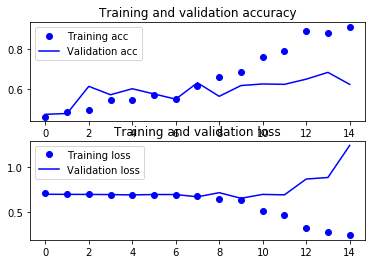

In [147]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()
